In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import joblib
import spacy
import numpy as np
import joblib

In [2]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 4.6 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


#### Do some elementary EDA on the data

In [3]:
data = pd.read_csv("../data/train_data.csv", header=None)

In [4]:
data.head()

,0,1
0,yew hedge,1221
1,fire detection shop,19
2,cheap couch roll,398
3,extra watermelon gum,1108
4,used generators for sale uk,213


<Axes: ylabel='Count'>

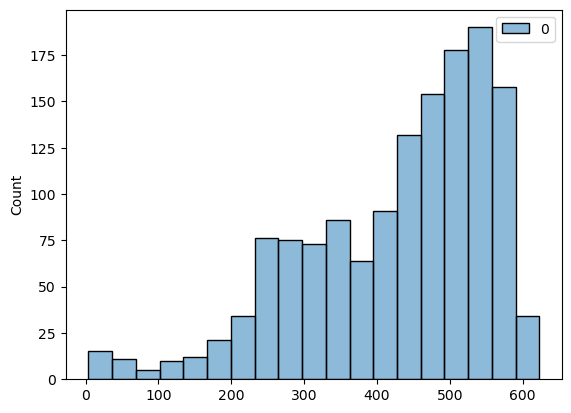

In [7]:
sns.histplot(data.groupby(1).count())

In [8]:
data.groupby(1).filter(lambda x: len(x) <250)

,0,1
0,yew hedge,1221
8,tyr fusion,158
13,car rental dublin airport,1069
71,childrens goggles,309
80,rfid card protector,1211
...,...,...
606598,wilma pot system,1302
606614,edea overture figure skates,788
606654,art and craft fairs scotland,1395
606750,human testing uk,1034


In [10]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [11]:
classes = data[1].unique().tolist()

In [12]:
class IntentClassifierSpacy:
    def __init__(self , intents , best_params = None):
        self.nlp = spacy.load('en_core_web_md')
        if not best_params:
            self.mlp = MLPClassifier(random_state=42, early_stopping=True)
        else:
            self.mlp = MLPClassifier(**best_params,random_state=42, early_stopping=True)
        self.intents = intents
        self.intent_to_label = {}
        self.intent_to_label = {intent: idx for idx, intent in enumerate(self.intents)}
    
    
    def fit(self, data, text_field , intent_field):
        data["labels"] = data[intent_field].apply(lambda x : self.intent_to_label[x])
        
        # Create Spacy embeddings
        data["spacy_embeddings"] = data[text_field].apply(lambda x : self.nlp(x).vector)
        
        # Train the MLP classifier
        self.mlp.fit(np.vstack(data['spacy_embeddings']), data['labels'])
    
    def predict(self, data, text_field):
        data["spacy_embeddings"] = data[text_field].apply(lambda x : self.nlp(x).vector)
        
        # Make predictions
        predicted_labels = self.mlp.predict(np.vstack(data['spacy_embeddings']))
        predicted_proba = self.mlp.predict_proba(np.vstack(data['spacy_embeddings']))
        predicted_intents = [self.intents[label] for label in predicted_labels]
        return predicted_labels , predicted_proba , predicted_intents

    def predict_one(self, text):
        embedding = self.nlp(text).vector.reshape(1, -1)
        predicted_label = self.mlp.predict(embedding)[0]
        predicted_proba = self.mlp.predict_proba(embedding)
        predicted_intent = self.intents[predicted_label]
        return predicted_label , predicted_proba , predicted_intent
        
    def evaluate(self, data, text_field , intent_field):
        # Convert intents to numerical labels
        data["labels"] = data[intent_field].apply(lambda x : self.intent_to_label[x])
        
        
        # Make predictions
        pred , _proba ,_intent = self.predict(data , text_field)
        
        # Evaluate the model
        return classification_report(data["labels"], pred, target_names=self.intents  , output_dict=True)
    
    def tune_hyperparameters(self, data, param_grid, text_field, intent_field):
        # Convert intents to numerical labels
        self.intents = data[intent_field].unique().tolist()
        self.intent_to_label = {intent: idx for idx, intent in enumerate(self.intents)}
        
        # Convert intents to numerical labels
        data["labels"] = data[intent_field].apply(lambda x : self.intent_to_label[x])
        data["spacy_embeddings"] = data[text_field].apply(lambda x : self.nlp(x).vector)
        
        # Perform grid search
        grid_search = GridSearchCV(self.mlp, param_grid, cv=3, n_jobs = -1 , verbose = 3)
        grid_search.fit(np.vstack(data['spacy_embeddings']), data['labels'])
        
        # Update the MLP classifier with the best parameters
        self.mlp = grid_search.best_estimator_
        
        # Print the best hyperparameters
        print("Best hyperparameters:", grid_search.best_params_)
        print("Best accuracy:", grid_search.best_score_)

In [ ]:
# Initialize the classifier
classifier = IntentClassifierSpacy(classes)

In [ ]:
# Define the parameter grid for hyperparameter tuning
parameter_space = {
    'hidden_layer_sizes': [(256, 128, 64), (128,100, 64)],
    'activation': ['tanh','relu'],
    'solver': ['adam'],
    'max_iter' : [100],
    'alpha': [0.5 , 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [ ]:
# Tune hyperparameters using grid search
classifier.tune_hyperparameters(train, parameter_space , text_field =0, intent_field = 1)

In [13]:
best_params = {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (256, 128, 64), 'learning_rate': 'constant', 'max_iter': 100, 'solver': 'adam'}

In [14]:
final_model = IntentClassifierSpacy(classes , best_params = best_params)

In [ ]:
final_model.fit(train , 0 , 1)

In [ ]:
test['predicted_intents'] = final_model.predict(test[0])

In [ ]:
precision_recall_fscore_support(test[1] , test['predicted_intents'] , average='weighted')

In [14]:
joblib.dump(final_model , "../models/spacy_classifier.joblib",compress = 1)

['../models/spacy_classifier.joblib']